In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

# ---------- Load Data ----------
labeled_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/bd_building_only_labeled.gpkg"
gdf_labeled = gpd.read_file(labeled_path)

# Drop unnecessary columns
drop_cols = ['fid', 'org_fid', 'building_category']
gdf_labeled = gdf_labeled.drop(columns=[c for c in drop_cols if c in gdf_labeled.columns], errors='ignore')

# Target and Features
target_col = 'binary_category'
X = gdf_labeled.drop(columns=[target_col, 'geometry'], errors='ignore')
y = gdf_labeled[target_col]

# Handle binary mask columns
binary_mask_cols = ['pop_missing', 'built-s_missing', 'ntl_missing', 'urban_index_missing']
if 'In_landuse_a' in X.columns:
    X['In_landuse_a'] = X['In_landuse_a'].astype(int)
for col in binary_mask_cols:
    if col in X.columns:
        X[col] = X[col].astype(int)

# Separate numeric and categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

# Convert categorical columns to string
for col in categorical_cols:
    X[col] = X[col].fillna('unknown').astype(str)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert categorical column names to indices for CatBoost
cat_feature_indices = [X_train.columns.get_loc(col) for col in categorical_cols]

# CatBoost model
cbc = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    l2_leaf_reg=3,
    loss_function='Logloss',
    eval_metric='F1',
    auto_class_weights='Balanced',  # ✅ Fixed
    random_seed=42,
    verbose=100
)

# GridSearch parameters
param_grid = {
    'iterations': [300, 400, 500],
    'depth': [6, 8],
    'learning_rate': [0.05, 0.1],
    'l2_leaf_reg': [3, 5]
}

grid_search = GridSearchCV(
    estimator=cbc,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1
)

print("Training CatBoost model (balanced) with GridSearchCV...")
grid_search.fit(X_train, y_train, cat_features=cat_feature_indices)  # ✅ Pass indices

# Best params
print(f"\n✅ Best Parameters: {grid_search.best_params_}")
print(f"✅ Best F1-score (CV): {grid_search.best_score_:.4f}")

# Evaluate
y_pred = grid_search.predict(X_test)
print("\n--- Classification Report (on Test Set) ---")
print(classification_report(y_test, y_pred))
print("--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))

# Save model
model_bundle = {
    'model': grid_search.best_estimator_,
    'features': X.columns.tolist(),
    'categorical_features': categorical_cols
}
model_save_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/cb_files/NOpsudo_cb_model.joblib"
joblib.dump(model_bundle, model_save_path)
print(f"✅ Model saved to: {model_save_path}")


Training CatBoost model (balanced) with GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
0:	learn: 0.7300801	total: 253ms	remaining: 1m 15s
100:	learn: 0.8642507	total: 9.59s	remaining: 18.9s
200:	learn: 0.8872160	total: 18.9s	remaining: 9.29s
299:	learn: 0.9019719	total: 28s	remaining: 0us

✅ Best Parameters: {'depth': 6, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.05}
✅ Best F1-score (CV): nan

--- Classification Report (on Test Set) ---
                 precision    recall  f1-score   support

non_residential       0.68      0.87      0.76      3084
    residential       0.97      0.91      0.94     14872

       accuracy                           0.91     17956
      macro avg       0.82      0.89      0.85     17956
   weighted avg       0.92      0.91      0.91     17956

--- Confusion Matrix ---
[[ 2691   393]
 [ 1279 13593]]
✅ Model saved to: D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/cb_files/NO

In [10]:
import geopandas as gpd
import numpy as np
import fiona
import joblib
import pandas as pd
import heapq

# ------------------------------
# Settings and file paths
# ------------------------------
model_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/cb_files/NOpsudo_cb_model.joblib"
output_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/cb_files/CB_bd_building_labeled_and_pseudo.gpkg"
full_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/bd_building_feat-dist_dem_ghs.gpkg"
labeled_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/bd_building_only_labeled.gpkg"
layer_name = 'fea-dist_dem_ghs'
target_col = 'binary_category'
drop_cols = ['fid', 'org_fid', 'building_category']
chunk_size = 500_000

# final target counts
TARGET_RES_COUNT = 600_000
TARGET_NONRES_COUNT = 200_000

# ------------------------------
# Load trained model and encoder
# ------------------------------
print("Loading model and label encoder...")
model_bundle = joblib.load(model_path)
grid_search.best_estimator_ = model_bundle['model']
categorical_cols = model_bundle['categorical_features']

# ------------------------------
# Streaming top-N selection (tie-safe)
# ------------------------------
print("Starting chunked pseudo-labeling with streaming top-N selection (tie-safe)...")

res_heap = []
nonres_heap = []
counter = 0  # for tie-breaking

def add_to_heap_tiesafe(heap, conf, row_dict, max_size):
    global counter
    entry = (float(conf), counter, row_dict)
    counter += 1
    if len(heap) < max_size:
        heapq.heappush(heap, entry)
        return
    min_conf = heap[0][0]
    if conf > min_conf:
        heapq.heapreplace(heap, entry)
    elif conf == min_conf:
        heapq.heappush(heap, entry)

# ------------------------------
# Process file in chunks
# ------------------------------
with fiona.Env():
    with fiona.open(full_path, layer=layer_name) as src:
        total = len(src)
        for i in range(0, total, chunk_size):
            start, stop = i, min(i + chunk_size, total)
            print(f"Processing rows {start} to {stop}...")

            gdf_chunk = gpd.read_file(full_path, rows=slice(start, stop), layer=layer_name)
            gdf_chunk = gdf_chunk.drop(columns=[c for c in drop_cols if c in gdf_chunk.columns], errors='ignore')

            mask_unlabeled = gdf_chunk[target_col].isna()
            if not mask_unlabeled.any():
                continue
            gdf_unlabeled = gdf_chunk[mask_unlabeled].copy()

            X = gdf_unlabeled.drop(columns=['geometry', target_col], errors='ignore')

            binary_mask_cols = ['pop_missing', 'built-s_missing', 'ntl_missing', 'urban_index_missing']
            if 'In_landuse_a' in X.columns:
                X['In_landuse_a'] = X['In_landuse_a'].astype(int)
            for col in binary_mask_cols:
                if col in X.columns:
                    X[col] = X[col].astype(int)

            for col in X.select_dtypes(include='object').columns:
                X[col] = X[col].fillna('unknown').astype(str)

            # Predict probabilities and labels
            probs = best_model.predict_proba(X)
            max_conf = np.max(probs, axis=1)
            pred_classes = np.argmax(probs, axis=1)
            pseudo_labels = le.inverse_transform(pred_classes)

            gdf_unlabeled[target_col] = pseudo_labels
            gdf_unlabeled['pseudo_labeled'] = 1
            gdf_unlabeled['confidence'] = max_conf

            cols_to_keep = list(gdf_unlabeled.columns)
            for local_idx in range(len(gdf_unlabeled)):
                row_series = gdf_unlabeled.iloc[local_idx]
                conf = float(row_series['confidence'])
                label = row_series[target_col]
                row_dict = {c: row_series[c] for c in cols_to_keep}
                if label == 'residential':
                    add_to_heap_tiesafe(res_heap, conf, row_dict, TARGET_RES_COUNT)
                elif label == 'non_residential':
                    add_to_heap_tiesafe(nonres_heap, conf, row_dict, TARGET_NONRES_COUNT)

# ------------------------------
# Build final pseudo dataset
# ------------------------------
print("Building final pseudo dataset from heaps...")
res_rows = [entry[2] for entry in res_heap]
nonres_rows = [entry[2] for entry in nonres_heap]

res_gdf = gpd.GeoDataFrame(pd.DataFrame(res_rows), geometry='geometry', crs=gdf_chunk.crs) if res_rows else gpd.GeoDataFrame(columns=gdf_chunk.columns)
nonres_gdf = gpd.GeoDataFrame(pd.DataFrame(nonres_rows), geometry='geometry', crs=gdf_chunk.crs) if nonres_rows else gpd.GeoDataFrame(columns=gdf_chunk.columns)

final_pseudo = gpd.GeoDataFrame(pd.concat([res_gdf, nonres_gdf], ignore_index=True), geometry='geometry', crs=gdf_chunk.crs)
print(f"✅ Final pseudo dataset size: {len(final_pseudo)}")
print(f"   Residential: {len(res_gdf)}, Non-residential: {len(nonres_gdf)}")

# ------------------------------
# Combine with labeled and save
# ------------------------------
print("Combining with labeled dataset...")
gdf_labeled = gpd.read_file(labeled_path)
gdf_labeled = gdf_labeled[gdf_labeled[target_col].notna()].copy()
gdf_labeled['pseudo_labeled'] = 0
gdf_labeled['confidence'] = 1.0

gdf_combined = gpd.GeoDataFrame(pd.concat([gdf_labeled, final_pseudo], ignore_index=True), geometry='geometry', crs=gdf_labeled.crs)

for col in ['pseudo_confidence', 'psudo confidence', 'psudo_confidence']:
    if col in gdf_combined.columns:
        gdf_combined.drop(columns=col, inplace=True)

print(f"Saving to {output_path} ...")
gdf_combined.to_file(output_path, driver="GPKG")
print("Done.")


Loading model and label encoder...
Starting chunked pseudo-labeling with streaming top-N selection (tie-safe)...
Processing rows 0 to 500000...
Processing rows 500000 to 1000000...
Processing rows 1000000 to 1500000...
Processing rows 1500000 to 2000000...
Processing rows 2000000 to 2500000...
Processing rows 2500000 to 3000000...
Processing rows 3000000 to 3500000...
Processing rows 3500000 to 4000000...
Processing rows 4000000 to 4500000...
Processing rows 4500000 to 5000000...
Processing rows 5000000 to 5500000...
Processing rows 5500000 to 6000000...
Processing rows 6000000 to 6500000...
Processing rows 6500000 to 7000000...
Processing rows 7000000 to 7500000...
Processing rows 7500000 to 8000000...
Processing rows 8000000 to 8500000...
Processing rows 8500000 to 9000000...
Processing rows 9000000 to 9500000...
Processing rows 9500000 to 10000000...
Processing rows 10000000 to 10500000...
Processing rows 10500000 to 10993410...
Building final pseudo dataset from heaps...
✅ Final ps

In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# ---------- Load pseudo-labeled dataset ----------
pseudo_label_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/cb_files/CB_bd_building_labeled_and_pseudo.gpkg"
gdf_pseudo = gpd.read_file(pseudo_label_path)

# ---------- Drop unnecessary columns ----------
drop_cols = ['fid', 'org_fid', 'building_category', 'pseudo_labeled', 'confidence']
gdf_pseudo = gdf_pseudo.drop(columns=[c for c in drop_cols if c in gdf_pseudo.columns], errors='ignore')

# ---------- Features & Target ----------
target_col = 'binary_category'
X = gdf_pseudo.drop(columns=[target_col, 'geometry'], errors='ignore')
y = gdf_pseudo[target_col]

# ---------- Handle binary mask columns ----------
binary_mask_cols = ['pop_missing', 'built-s_missing', 'ntl_missing', 'urban_index_missing']
if 'In_landuse_a' in X.columns:
    X['In_landuse_a'] = X['In_landuse_a'].astype(int)
for col in binary_mask_cols:
    if col in X.columns:
        X[col] = X[col].astype(int)

# ---------- Separate numeric & categorical ----------
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

# ---------- Convert categorical columns to string ----------
for col in categorical_cols:
    X[col] = X[col].fillna('unknown').astype(str)

# ---------- Encode target ----------
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ---------- Train-test split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ---------- CatBoost model (optimized hyperparameters, no balancing) ----------
cat_feature_indices = [X_train.columns.get_loc(c) for c in categorical_cols]

cbc = CatBoostClassifier(
    iterations=300,      
    depth=6,             
    learning_rate=0.05,  
    l2_leaf_reg=3,       
    loss_function='Logloss',
    eval_metric='F1',
    random_seed=42,
    verbose=100
)

print("Training CatBoost on pseudo-labeled dataset...")
cbc.fit(X_train, y_train, cat_features=cat_feature_indices)

# ---------- Evaluate ----------
y_pred = cbc.predict(X_test)
print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))

# ---------- Validate on Ground-Truth Labeled Dataset ----------
val_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/bd_building_only_labeled.gpkg"
gdf_val = gpd.read_file(val_path)

# Keep only the features used in training
X_val = gdf_val[X.columns].copy()  # ensures geometry & extra columns are removed
y_val = gdf_val[target_col]

# Handle masks & categorical
if 'In_landuse_a' in X_val.columns:
    X_val['In_landuse_a'] = X_val['In_landuse_a'].astype(int)
for col in binary_mask_cols:
    if col in X_val.columns:
        X_val[col] = X_val[col].astype(int)
for col in categorical_cols:
    X_val[col] = X_val[col].fillna('unknown').astype(str)

# Encode & predict
y_val_encoded = le.transform(y_val)
y_val_pred = cbc.predict(X_val)

print("\n--- Classification Report (Ground-Truth Validation) ---")
print(classification_report(y_val_encoded, y_val_pred, target_names=le.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_val_encoded, y_val_pred))


Training CatBoost on pseudo-labeled dataset...
0:	learn: 0.9575577	total: 785ms	remaining: 3m 54s
100:	learn: 0.9918992	total: 1m 1s	remaining: 2m
200:	learn: 0.9934303	total: 2m 2s	remaining: 1m
299:	learn: 0.9939856	total: 3m 3s	remaining: 0us

--- Classification Report (Test Set) ---
                 precision    recall  f1-score   support

non_residential       0.98      0.98      0.98     43084
    residential       0.99      0.99      0.99    134872

       accuracy                           0.99    177956
      macro avg       0.99      0.99      0.99    177956
   weighted avg       0.99      0.99      0.99    177956

--- Confusion Matrix ---
[[ 42268    816]
 [   890 133982]]

--- Classification Report (Ground-Truth Validation) ---
                 precision    recall  f1-score   support

non_residential       0.73      0.76      0.74     15418
    residential       0.95      0.94      0.95     74359

       accuracy                           0.91     89777
      macro avg     

In [4]:
# ---------- Save model ----------
model_bundle = {
    'model': cbc,
    'label_encoder': le,
    'features': X.columns.tolist(),
    'categorical_features': categorical_cols
}
model_save_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/cb_files/final_cb_model_psedo.joblib"
joblib.dump(model_bundle, model_save_path)
print(f"✅ Model saved to: {model_save_path}")

✅ Model saved to: D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/cb_files/final_cb_model_psedo.joblib


In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import fiona
import joblib
from catboost import CatBoostClassifier, Pool

# --- Paths & Config ---
model_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/cb_files/final_cb_model_psedo.joblib"
input_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/bd_building_feat-dist_dem_ghs.gpkg"
output_path = "D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/cb_files/CB_final_predictions.gpkg"
layer_name = 'fea-dist_dem_ghs'
chunk_size = 500_000
target_col = 'binary_category'
drop_cols = ['fid', 'org_fid', 'building_category']

# --- Load trained model ---
print("📦 Loading trained CatBoost model...")
model_bundle = joblib.load(model_path)
cbc = model_bundle['model']
categorical_cols = model_bundle['categorical_features']
features = model_bundle['features']
le = model_bundle.get('label_encoder', None)

# --- Get categorical feature indices ---
cat_features_idx = [features.index(c) for c in categorical_cols if c in features]

# --- Process data in chunks ---
all_chunks = []

with fiona.Env():
    with fiona.open(input_path, layer=layer_name) as src:
        total_rows = len(src)
        print(f"📄 Total rows to process: {total_rows}")

        for i in range(0, total_rows, chunk_size):
            print(f"🔄 Processing rows {i} to {min(i + chunk_size, total_rows)}...")
            gdf = gpd.read_file(input_path, rows=slice(i, i + chunk_size), layer=layer_name)

            # Drop unused columns
            gdf = gdf.drop(columns=[c for c in drop_cols if c in gdf.columns], errors='ignore')

            # Create 'predict_label': 1 if unlabeled (target is NaN), else 0
            if target_col not in gdf.columns:
                gdf[target_col] = np.nan
            gdf['predict_label'] = gdf[target_col].isna().astype(int)

            # Ensure all expected features exist
            for f in features:
                if f not in gdf.columns:
                    gdf[f] = 0

            # Convert categorical columns to strings
            for c in categorical_cols:
                if c in gdf.columns:
                    gdf[c] = gdf[c].fillna('unknown').astype(str)

            # --- Create Pool and predict ---
            data_pool = Pool(data=gdf[features], cat_features=cat_features_idx)
            preds = cbc.predict(data_pool)
            probs = cbc.predict_proba(data_pool)
            confs = np.max(probs, axis=1)

            # Map predictions back to original labels if label encoder exists
            if le:
                gdf['Predicted'] = le.inverse_transform(preds.astype(int))
            else:
                gdf['Predicted'] = preds
            gdf['confidence'] = confs

            all_chunks.append(gdf)

# --- Combine and save ---
gdf_all = pd.concat(all_chunks, ignore_index=True)
gdf_all = gpd.GeoDataFrame(gdf_all, geometry='geometry', crs=gdf.crs)
gdf_all.to_file(output_path, driver="GPKG")
print(f"\n✅ Final predictions saved to:\n{output_path}")

# --- Evaluate on labeled data if available ---
if target_col in gdf_all.columns:
    labeled = gdf_all[gdf_all['predict_label'] == 0]
    if not labeled.empty:
        if le:
            y_true = le.transform(labeled[target_col])
            y_pred = le.transform(labeled['Predicted'])
        else:
            y_true = labeled[target_col].astype(str)
            y_pred = labeled['Predicted'].astype(str)

        print("\n📊 Evaluation on Labeled Buildings:")
        from sklearn.metrics import classification_report, confusion_matrix
        print(classification_report(y_true, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_true, y_pred))
    else:
        print("⚠️ No labeled rows found for evaluation.")
else:
    print("⚠️ Target column not found; skipping evaluation.")


📦 Loading trained CatBoost model...
📄 Total rows to process: 10993410
🔄 Processing rows 0 to 500000...
🔄 Processing rows 500000 to 1000000...
🔄 Processing rows 1000000 to 1500000...
🔄 Processing rows 1500000 to 2000000...
🔄 Processing rows 2000000 to 2500000...
🔄 Processing rows 2500000 to 3000000...
🔄 Processing rows 3000000 to 3500000...
🔄 Processing rows 3500000 to 4000000...
🔄 Processing rows 4000000 to 4500000...
🔄 Processing rows 4500000 to 5000000...
🔄 Processing rows 5000000 to 5500000...
🔄 Processing rows 5500000 to 6000000...
🔄 Processing rows 6000000 to 6500000...
🔄 Processing rows 6500000 to 7000000...
🔄 Processing rows 7000000 to 7500000...
🔄 Processing rows 7500000 to 8000000...
🔄 Processing rows 8000000 to 8500000...
🔄 Processing rows 8500000 to 9000000...
🔄 Processing rows 9000000 to 9500000...
🔄 Processing rows 9500000 to 10000000...
🔄 Processing rows 10000000 to 10500000...
🔄 Processing rows 10500000 to 10993410...

✅ Final predictions saved to:
D:/VS Code/Building cl

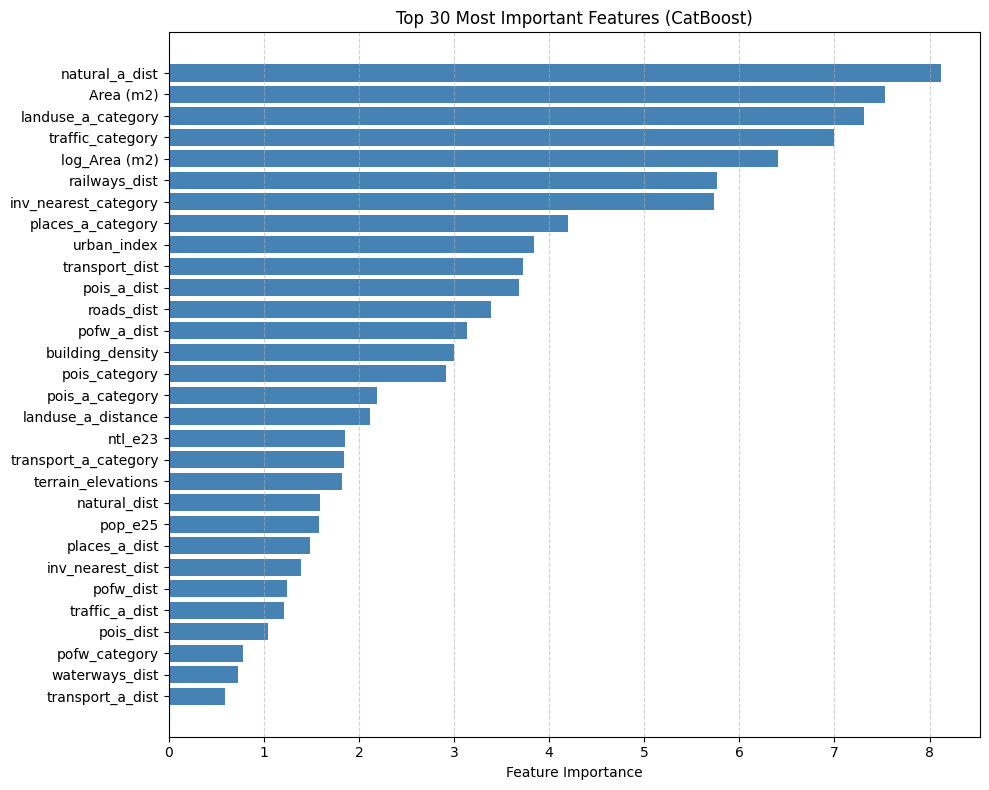

In [3]:
import joblib
import numpy as np
import matplotlib.pyplot as plt

# --- Load saved CatBoost model bundle ---
saved = joblib.load("D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/cb_files/final_cb_model_psedo.joblib")
model = saved['model']               # CatBoostClassifier
feature_names = np.array(saved['features'])  # feature names used during training

# --- Get feature importances ---
importances = model.get_feature_importance()

# --- Sort and select top N features ---
top_n = 30
indices = np.argsort(importances)[::-1][:top_n]
top_features = feature_names[indices]
top_importances = importances[indices]

# --- Plot horizontal bar chart ---
plt.figure(figsize=(10, 8))
plt.barh(top_features[::-1], top_importances[::-1], color='steelblue')
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Most Important Features (CatBoost)")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
import fiona
import pandas as pd

rf_path = r"D:/VS Code/Building classification/gis/Data_files/BD_Dataset_OSM/UTM 46N/final layers/cb_files/CB_final_predictions.gpkg"
pred_col = "Predicted"  

# Open the file without geometry
with fiona.open(rf_path, layer=0) as src:
    # Extract only the prediction column from attributes
    pred_values = [feat["properties"][pred_col] for feat in src]

# Create dataframe from predictions
df = pd.DataFrame(pred_values, columns=[pred_col])

# Count & percentage
counts = df[pred_col].value_counts()
total = len(df)
percent = (counts / total * 100).round(2)

# Summary table
summary = counts.to_frame(name="Count")
summary["Percentage"] = percent

print("\n📊 CB Prediction Summary:")
print(summary)
print("\n🏠 Total Buildings:", total)
print(f"Residential: {counts.get('residential', 0)} ({percent.get('residential', 0)}%)")
print(f"Non-residential: {counts.get('non_residential', 0)} ({percent.get('non_residential', 0)}%)")

if counts.get('non_residential', 0) != 0:
    ratio = counts.get('residential', 0) / counts.get('non_residential', 0)
    print(f"\n📈 Residential to Non-residential Ratio: {ratio:.2f} : 1")



📊 RF Prediction Summary:
                   Count  Percentage
Predicted                           
residential      8974362       81.63
non_residential  2019048       18.37

🏠 Total Buildings: 10993410
Residential: 8974362 (81.63%)
Non-residential: 2019048 (18.37%)

📈 Residential to Non-residential Ratio: 4.44 : 1
